In [1]:
import sklearn
import pandas as pd

In [22]:
import pickle

with open('../yk_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

yk_full = data['yk_full']
yk_dropped = data['yk_dropped']

with open('../ty_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

ty_full = data['ty_full']
ty_dropped = data['ty_dropped']


with open('../luna_dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

luna_full = data['luna_full']
luna_dropped = data['luna_dropped']

In [21]:
luna_full_filled = luna_full.fillna(0)

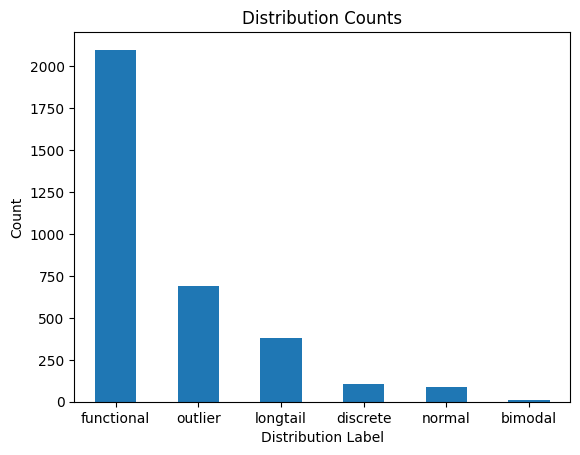

In [5]:
distribution_counts = luna_full_filled['Distribution Type'].value_counts()

import matplotlib.pyplot as plt

distribution_counts.plot(kind='bar')
plt.title('Distribution Counts')
plt.xlabel('Distribution Label')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

In [33]:
from sklearn.model_selection import train_test_split

columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X = luna_full_filled.drop(columns = columns_to_drop)
y = luna_full_filled['Target_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [35]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9554896142433235
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       468
           1       0.94      0.92      0.93       206

    accuracy                           0.96       674
   macro avg       0.95      0.94      0.95       674
weighted avg       0.96      0.96      0.96       674



In [36]:
y.value_counts()

Target_Encoded
0    2300
1    1070
Name: count, dtype: int64

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [38]:
model_smote = RandomForestClassifier() # class_weight={0: 1, 1: 10}
model_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = model_smote.predict(X_test)
y_pred_smote_adjusted = (model_smote.predict_proba(X_test)[:, 1] >= 0.35).astype(int) # f1_threshold calculated below

In [39]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))

Accuracy: 0.9554896142433235
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       468
           1       0.92      0.94      0.93       206

    accuracy                           0.96       674
   macro avg       0.95      0.95      0.95       674
weighted avg       0.96      0.96      0.96       674



In [45]:
import pickle

with open('luna_only_model.pkl', 'wb') as file:
    pickle.dump(model_smote, file)

In [43]:
y_pred_smote_adjusted = (model_smote.predict_proba(X_test)[:, 1] >= 0.59).astype(int) # f1_threshold calculated below

In [44]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_smote_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_smote_adjusted))

Accuracy: 0.9599406528189911
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       468
           1       0.94      0.93      0.93       206

    accuracy                           0.96       674
   macro avg       0.95      0.95      0.95       674
weighted avg       0.96      0.96      0.96       674



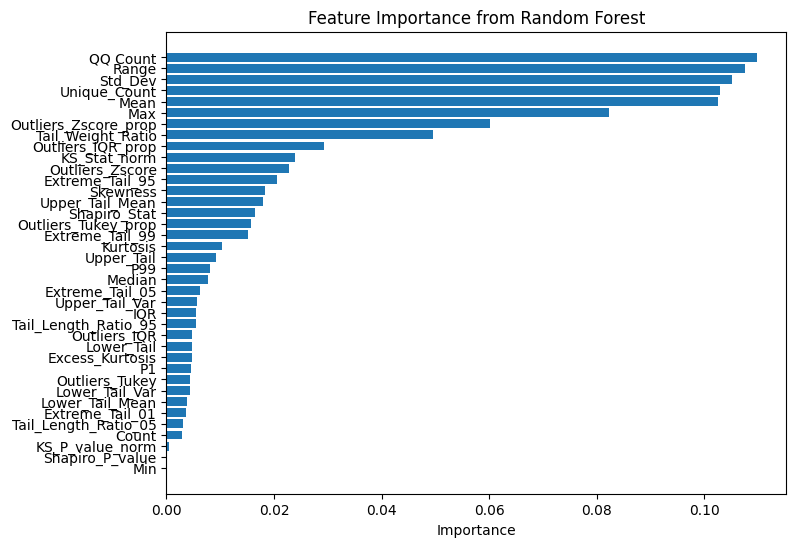

In [19]:
import pandas as pd
import matplotlib as plt

importances = model_smote.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

In [32]:
y_pred_all = model.predict(X)

unrecalled_mask = (y == 1) & (y_pred_all != 1)
unrecalled_points = X[unrecalled_mask]

recalled_mask = (y == 1) & (y_pred_all == 1)
recalled_points = X[recalled_mask]

unrecalled_points.index

Index([  17, 1491, 1494, 1501, 1563, 1780, 1782, 1783, 1860, 1862, 1867, 1922,
       1983, 1985, 1990, 1991, 2057, 2059, 2060, 2133, 2134, 2245, 2249, 2261,
       2262, 2334, 2630, 2646, 2648, 2657, 2690, 2699, 2714, 2739, 2909],
      dtype='int64')

# Calculating threshold to maximize f1 score

In [42]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_probs = model_smote.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# best threshold for recall
recall_idx = np.argmax(recalls)
recall_threshold = thresholds[recall_idx]

# best threshld for f1 score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_idx = np.argmax(f1_scores)
f1_threshold = thresholds[f1_idx]

print(f1_threshold)

0.59


# Predict on yk data

In [54]:
yk_full_filled = yk_full.fillna(0)

In [55]:
columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X_yk = yk_full_filled.drop(columns = columns_to_drop)
y_yk = yk_full_filled['Target_Encoded']

In [59]:
y_pred_yk = model_smote.predict(X_yk)
y_pred_yk_adjusted = (model_smote.predict_proba(X_yk)[:, 1] >= 0.38).astype(int)

In [57]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_yk, y_pred_yk))
print("Classification Report:\n", classification_report(y_yk, y_pred_yk))

Accuracy: 0.8117073170731708
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78       490
           1       0.78      0.90      0.83       535

    accuracy                           0.81      1025
   macro avg       0.82      0.81      0.81      1025
weighted avg       0.82      0.81      0.81      1025



In [60]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_yk, y_pred_yk_adjusted))
print("Classification Report:\n", classification_report(y_yk, y_pred_yk_adjusted))

Accuracy: 0.7482926829268293
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.49      0.65       490
           1       0.68      0.99      0.80       535

    accuracy                           0.75      1025
   macro avg       0.82      0.74      0.73      1025
weighted avg       0.82      0.75      0.73      1025



# Predict on TY data

In [61]:
ty_full_filled = ty_full.fillna(0)

In [62]:
columns_to_drop = ['Target', 'Name', 'Distribution Type', 'Target_Encoded']
X_ty = ty_full_filled.drop(columns = columns_to_drop)
y_ty = ty_full_filled['Target_Encoded']

In [63]:
y_pred_ty = model_smote.predict(X_ty)
y_pred_ty_adjusted = (model_smote.predict_proba(X_ty)[:, 1] >= 0.38).astype(int)

In [64]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_ty, y_pred_ty))
print("Classification Report:\n", classification_report(y_ty, y_pred_ty))

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_ty, y_pred_ty_adjusted))
print("Classification Report:\n", classification_report(y_ty, y_pred_ty_adjusted))

Accuracy: 0.5221112696148359
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.46      0.63      1239
           1       0.19      0.97      0.32       163

    accuracy                           0.52      1402
   macro avg       0.59      0.72      0.48      1402
weighted avg       0.90      0.52      0.60      1402

Accuracy: 0.4044222539229672
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.49      1239
           1       0.16      1.00      0.28       163

    accuracy                           0.40      1402
   macro avg       0.58      0.66      0.39      1402
weighted avg       0.90      0.40      0.47      1402

